### Multi-Task Learning Model for Battery Health Prediction

This notebook implements a multi-task learning approach for battery health prediction,
including State of Health (SOH), Remaining Useful Life (RUL), and Discharge Capacity Change Rate (DCCR) 
prediction using gradient reversal and auxiliary networks.


This code is for model training and testing based on the optimal hyperparamters.


In [1]:
import torch
import numpy as np
import scipy.io
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from torch.autograd import grad

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

device(type='cuda')

In [2]:
# =============================================================================
# Data Loading and Preprocessing
# =============================================================================

# Battery batch identifiers
batch_list = ['batch01', 'batch02', 'batch03', 'batch04', 'batch05', 'batch06', 'batch07',
              'batch08', 'batch09', 'batch10', 'batch11', 'batch12', 'batch13', 'batch14',
              'batch15', 'batch16', 'batch17', 'batch18', 'batch19', 'batch20', 'batch21']

# Load battery degradation data
CM_data = scipy.io.loadmat('CM_Data1126.mat')
CM_data_aux = scipy.io.loadmat('CM_data_aux_label.mat')


In [10]:
# =============================================================================
# Utility Functions
# =============================================================================

def accuracy_cal(pred, test_label):
    """
    Calculate regression metrics for model evaluation
    
    Args:
        pred: Predicted values
        test_label: Ground truth values
    
    Returns:
        tuple: (RMSE, MAE, MAPE, R²)
    """
    test_rmse = torch.sqrt(torch.mean(torch.square(pred - test_label)))
    test_mae = torch.mean(torch.abs(pred - test_label))
    test_mape = torch.mean(torch.abs(pred - test_label) / (test_label + 1e-5))
    mse = torch.mean(torch.mean(torch.square(pred - test_label)))
    test_r2 = 1 - mse / torch.var(pred)
    return test_rmse.cpu().detach().numpy(), test_mae.cpu().detach().numpy(), \
           test_mape.cpu().detach().numpy(), test_r2.cpu().detach().numpy()

# RUL scaling factor
theta_RUL = 0.001

def extract_feature(batch_num, battery_num):
    """
    Extract features and labels from battery data
    
    Args:
        batch_num: Batch identifier
        battery_num: Battery identifier within batch
    
    Returns:
        tuple: (features, SOH_labels, RUL_labels, auxiliary_labels)
    """
    CM_len = len(CM_data['feature_CM'][0, 0][batch_num][0, battery_num]['feature_30'])
    index_failure = np.where(CM_data['feature_CM'][0, 0][batch_num][0, battery_num]['SOH'] >= 0.5)
    
    # Extract labels
    RUL_label = CM_data['feature_CM'][0, 0][batch_num][0, battery_num]['RUL'].reshape(-1, 1)
    len_data = len(RUL_label)
    
    # Extract features and labels
    CM_feature = CM_data['feature_CM'][0, 0][batch_num][0, battery_num]['feature_40'][:len_data]
    SOH_label = CM_data['feature_CM'][0, 0][batch_num][0, battery_num]['SOH'][:, :len_data].reshape(-1, 1)
    aux_label = CM_data_aux['aux_lable'][0, 0][batch_num][0, battery_num]['dV_dQ_area'][:, :len_data].reshape(-1, 1)
    
    # Concatenate features with cycle index
    feature = np.concatenate((CM_feature, np.arange(CM_feature.shape[0]).reshape(-1, 1)), axis=1)
    
    return feature, SOH_label, RUL_label * theta_RUL, aux_label * 0.01

def predict_with_uncertainty(model, X, num_samples=100):
    """
    Perform uncertainty quantification using Monte Carlo dropout
    
    Args:
        model: Trained model
        X: Input features
        num_samples: Number of MC samples
    
    Returns:
        tuple: Mean and std predictions for all three tasks
    """
    model.eval()
    prediction1, prediction2, prediction3 = [], [], []
    
    for _ in range(num_samples):
        model.train()  # Enable dropout
        pred1, pred2, pred3 = model(X)
        prediction1.append(pred1)
        prediction2.append(pred2)
        prediction3.append(pred3)
    
    # Stack predictions and compute statistics
    prediction1 = torch.stack(prediction1, dim=0)
    prediction2 = torch.stack(prediction2, dim=0)
    prediction3 = torch.stack(prediction3, dim=0)
    
    pred_mean1 = prediction1.mean(dim=0)
    pred_std1 = prediction1.std(dim=0)
    pred_mean2 = prediction2.mean(dim=0)
    pred_std2 = prediction2.std(dim=0)
    pred_mean3 = prediction3.mean(dim=0)
    pred_std3 = prediction3.std(dim=0)
    
    return pred_mean1, pred_std1, pred_mean2, pred_std2, pred_mean3, pred_std3

def model_test(model, test_loader, test_y1, uncertainty_state=True):
    """
    Comprehensive model testing with visualization
    
    Args:
        model: Trained model
        test_loader: Test data loader
        test_y1: Ground truth labels
        uncertainty_state: Whether to compute uncertainty
    
    Returns:
        tuple: Test metrics and predictions for all tasks
    """
    test_SOH_all1 = torch.tensor([])
    test_RUL_all1 = torch.tensor([])
    test_DCCR_all1 = torch.tensor([])
    
    if uncertainty_state:
        test_pred_all1 = torch.tensor([])
        test_pred_std1 = torch.tensor([])
        test_pred_all2 = torch.tensor([])
        test_pred_std2 = torch.tensor([])
        test_pred_all3 = torch.tensor([])
        test_pred_std3 = torch.tensor([])
        
        # Collect predictions with uncertainty
        for step, (test_x, test_SOH, test_RUL, test_DCCR) in enumerate(test_loader):
            pred1, std1, pred2, std2, pred3, std3 = predict_with_uncertainty(model, test_x.to(device), num_samples=60)
            
            test_pred_all1 = torch.cat((test_pred_all1.to(device), pred1.to(device)), dim=0)
            test_pred_std1 = torch.cat((test_pred_std1.to(device), std1.to(device)), dim=0)
            test_pred_all2 = torch.cat((test_pred_all2.to(device), pred2.to(device)), dim=0)
            test_pred_std2 = torch.cat((test_pred_std2.to(device), std2.to(device)), dim=0)
            test_pred_all3 = torch.cat((test_pred_all3.to(device), pred3.to(device)), dim=0)
            test_pred_std3 = torch.cat((test_pred_std3.to(device), std3.to(device)), dim=0)
            
            test_SOH_all1 = torch.cat((test_SOH_all1.to(device), test_SOH.to(device)), dim=0)
            test_RUL_all1 = torch.cat((test_RUL_all1.to(device), test_RUL.to(device)), dim=0)
            test_DCCR_all1 = torch.cat((test_DCCR_all1.to(device), test_DCCR.to(device)), dim=0)
    else:
        model.eval()
        test_pred_all1 = torch.tensor([])
        test_pred_all2 = torch.tensor([])
        test_pred_all3 = torch.tensor([])
        
        # Collect predictions without uncertainty
        for step, (test_x, test_SOH, test_RUL, test_DCCR) in enumerate(test_loader):
            pred1, pred2, pred3 = model(test_x.to(device))
            
            test_pred_all1 = torch.cat((test_pred_all1.to(device), pred1.to(device)), dim=0)
            test_pred_all2 = torch.cat((test_pred_all2.to(device), pred2.to(device)), dim=0)
            test_pred_all3 = torch.cat((test_pred_all3.to(device), pred3.to(device)), dim=0)
            test_SOH_all1 = torch.cat((test_SOH_all1.to(device), test_SOH.to(device)), dim=0)
            test_RUL_all1 = torch.cat((test_RUL_all1.to(device), test_RUL.to(device)), dim=0)
            test_DCCR_all1 = torch.cat((test_DCCR_all1.to(device), test_DCCR.to(device)), dim=0)
    
    # Calculate metrics for all tasks
    test_rmse1, test_mae1, test_mape1, test_r21 = accuracy_cal(test_pred_all1, test_SOH_all1.to(device))
    print('SOH Testing results', '\nMAPE: ', test_mape1, '\nRMSE: ', test_rmse1, '\nMAE: ', test_mae1, '\nR²: ', test_r21)
    
    test_rmse2, test_mae2, test_mape2, test_r22 = accuracy_cal(test_pred_all2/theta_RUL, test_RUL_all1.to(device)/theta_RUL)
    print('RUL Testing results', '\nMAPE: ', test_mape2, '\nRMSE: ', test_rmse2, '\nMAE: ', test_mae2, '\nR²: ', test_r22)
    
    test_rmse3, test_mae3, test_mape3, test_r23 = accuracy_cal(test_pred_all3, test_DCCR_all1.to(device))
    print('DCCR Testing results', '\nMAPE: ', test_mape3, '\nRMSE: ', test_rmse3, '\nMAE: ', test_mae3, '\nR²: ', test_r23)

    # Visualization functions
    def plot_time_series(predictions, ground_truth, title):
        """Plot time series comparison"""
        plt.figure(figsize=(36, 6))
        cycle = np.array(range(len(predictions)))
        plt.plot(cycle, predictions.cpu().detach().numpy(), label='Predicted')
        plt.plot(cycle, ground_truth.cpu().detach().numpy(), label='Ground Truth')
        plt.title(title)
        plt.legend()
        plt.show()

    def plot_scatter_with_uncertainty(predictions, ground_truth, std_dev, errors, title, xlabel, ylabel):
        """Plot scatter plot with uncertainty bars"""
        plt.figure(figsize=(7.5/1.1, 6/1.1))
        
        if uncertainty_state:
            plt.errorbar(
                ground_truth.cpu().detach().numpy(),
                predictions.cpu().detach().numpy().reshape(-1,),
                yerr=std_dev.cpu().detach().numpy().reshape(-1,),
                fmt='none',
                ecolor='lightgray',
                capsize=1,
                label='Predicted Mean ± Std Dev',
                zorder=1
            )
        
        scatter = plt.scatter(
            ground_truth.cpu().detach().numpy(), 
            predictions.cpu().detach().numpy(), 
            c=errors,
            s=10 + errors/3,
            cmap='coolwarm',
            alpha=0.8,
            zorder=2
        )
        
        cbar = plt.colorbar(scatter)
        cbar.set_label('Error', fontsize=12)
        
        # Perfect prediction line
        min_val = ground_truth.cpu().detach().numpy().min()
        max_val = ground_truth.cpu().detach().numpy().max()
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
        
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.title(title)
        plt.tight_layout()
        plt.show()

    # SOH visualizations
    plot_time_series(test_pred_all1, test_SOH_all1, 'SOH Time Series')
    mape_errors1 = np.abs((test_SOH_all1.cpu().detach().numpy() - test_pred_all1.cpu().detach().numpy()) / test_SOH_all1.cpu().detach().numpy()) * 100
    plot_scatter_with_uncertainty(test_pred_all1, test_SOH_all1, 
                                 test_pred_std1 if uncertainty_state else None, 
                                 mape_errors1, 'SOH Prediction', 'True SOH', 'Predicted SOH')
    
    # RUL visualizations
    plot_time_series(test_pred_all2/theta_RUL, test_RUL_all1/theta_RUL, 'RUL Time Series')
    mae_errors2 = np.abs((test_RUL_all1.cpu().detach().numpy()/theta_RUL - test_pred_all2.cpu().detach().numpy()/theta_RUL))
    plot_scatter_with_uncertainty(test_pred_all2/theta_RUL, test_RUL_all1/theta_RUL,
                                 test_pred_std2/theta_RUL if uncertainty_state else None,
                                 mae_errors2, 'RUL Prediction', 'True RUL', 'Predicted RUL')
    
    # dV/dQ area visualizations
    plot_time_series(test_pred_all3, test_DCCR_all1, 'dV/dQ Area Time Series')
    mae_errors3 = np.abs((test_DCCR_all1.cpu().detach().numpy() - test_pred_all3.cpu().detach().numpy()))
    plot_scatter_with_uncertainty(test_pred_all3, test_DCCR_all1,
                                 test_pred_std3 if uncertainty_state else None,
                                 mae_errors3, 'dV/dQ Area Prediction', 'True dV_dQ_area', 'Predicted dV_dQ_area')
    
    # Return results
    if uncertainty_state:
        return (test_rmse1, test_mae1, test_mape1, test_r21, test_pred_all1, test_pred_std1,
                test_rmse2, test_mae2, test_mape2, test_r22, test_pred_all2, test_pred_std2,
                test_rmse3, test_mae3, test_mape3, test_r23, test_pred_all3, test_pred_std3)
    else:
        return (test_rmse1, test_mae1, test_mape1, test_r21, test_pred_all1,
                test_rmse2, test_mae2, test_mape2, test_r22, test_pred_all2,
                test_rmse3, test_mae3, test_mape3, test_r23, test_pred_all3)


In [ ]:
# =============================================================================
# Data Preparation
# =============================================================================

# Test battery configuration (one battery per batch for testing)
test_battery = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Data preparation for cross-validation
for test_battery_num in [3]:  # Can be modified for different test scenarios
    train_feature = np.array([])
    train_SOH_label = np.array([])
    train_RUL_label = np.array([])
    train_DCCR_label = np.array([])
    
    test_feature = np.array([])
    test_SOH_label = np.array([])
    test_RUL_label = np.array([])
    test_DCCR_label = np.array([])
    
    # Extract features from all batches
    for batch_num in range(21):
        for battery_num in range(4):
            feature, SOH_label, RUL_label, DCCR_label = extract_feature(batch_num, battery_num)
            
            if battery_num != test_battery[batch_num]:
                # Training data
                try:
                    train_feature = np.concatenate((train_feature, feature), axis=0)
                    train_SOH_label = np.concatenate((train_SOH_label, SOH_label), axis=0)
                    train_RUL_label = np.concatenate((train_RUL_label, RUL_label), axis=0)
                    train_DCCR_label = np.concatenate((train_DCCR_label, DCCR_label), axis=0)
                except:
                    train_feature = feature
                    train_SOH_label = SOH_label
                    train_RUL_label = RUL_label
                    train_DCCR_label = DCCR_label
            else:
                # Test data
                try:
                    test_feature = np.concatenate((test_feature, feature), axis=0)
                    test_SOH_label = np.concatenate((test_SOH_label, SOH_label), axis=0)
                    test_RUL_label = np.concatenate((test_RUL_label, RUL_label), axis=0)
                    test_DCCR_label = np.concatenate((test_DCCR_label, DCCR_label), axis=0)
                except:
                    test_feature = feature
                    test_SOH_label = SOH_label
                    test_RUL_label = RUL_label
                    test_DCCR_label = DCCR_label

    print(f"Training data shapes:")
    print(f"Features: {train_feature.shape}")
    print(f"SOH labels: {train_SOH_label.shape}")
    print(f"RUL labels: {train_RUL_label.shape}")
    print(f"DCCR labels: {train_DCCR_label.shape}")
    
    print(f"\nTest data shapes:")
    print(f"Features: {test_feature.shape}")
    print(f"SOH labels: {test_SOH_label.shape}")
    print(f"RUL labels: {test_RUL_label.shape}")
    print(f"DCCR labels: {test_DCCR_label.shape}")


In [ ]:
# =============================================================================
# Data Normalization and Tensor Conversion
# =============================================================================

# Normalize features using training data statistics
max_train_feature = np.max(train_feature, axis=0)
min_train_feature = np.min(train_feature, axis=0)

train_feature = (train_feature - min_train_feature) / (max_train_feature - min_train_feature)
test_feature = (test_feature - min_train_feature) / (max_train_feature - min_train_feature)

# Convert to PyTorch tensors
train_x = torch.from_numpy(train_feature).float()
train_SOH = torch.from_numpy(train_SOH_label).float()
train_RUL = torch.from_numpy(train_RUL_label).float()
train_DCCR = torch.from_numpy(train_DCCR_label).float()

test_x = torch.from_numpy(test_feature).float()
test_SOH = torch.from_numpy(test_SOH_label).float()
test_RUL = torch.from_numpy(test_RUL_label).float()
test_DCCR = torch.from_numpy(test_DCCR_label).float()

# Create data loaders
train_dataset = TensorDataset(train_x, train_SOH, train_RUL, train_DCCR)
test_dataset = TensorDataset(test_x, test_SOH, test_RUL, test_DCCR)

train_loader = DataLoader(dataset=train_dataset, batch_size=128*128*16, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128*128*16, shuffle=False)


In [ ]:
# =============================================================================
# Model Architecture
# =============================================================================

class GradReverse(torch.autograd.Function):
    """Gradient reversal layer for adversarial training"""
    @staticmethod
    def forward(ctx, x, lambd=1.0):
        ctx.lambd = lambd
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg().mul(ctx.lambd), None

def grad_reverse(x, lambd=1.0):
    """Gradient reversal function"""
    return GradReverse.apply(x, lambd)

class MLP(nn.Module):
    """Multi-Layer Perceptron with configurable architecture"""
    def __init__(self, input_dim=59, output_dim=1, layers_num=4, hidden_dim=50, dropout=0.01):
        super(MLP, self).__init__()
        
        assert layers_num >= 2, "layers must be greater than 2"
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers_num = layers_num
        self.hidden_dim = hidden_dim

        self.layers = []
        for i in range(layers_num):
            if i == 0:
                self.layers.append(nn.Linear(input_dim, hidden_dim))
                self.layers.append(nn.ReLU())
            elif i == layers_num - 1:
                self.layers.append(nn.Linear(hidden_dim, output_dim))
            else:
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(p=dropout))
        
        self.net = nn.Sequential(*self.layers)
        self._init()

    def _init(self):
        """Initialize network weights"""
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        return self.net(x)

class Solution_u(nn.Module):
    """
    Multi-task learning model with shared encoder and task-specific decoders
    
    Architecture:
    - Shared encoder: Extracts common features
    - SOH predictor: Predicts State of Health
    - RUL predictor: Predicts Remaining Useful Life
    - DCCR predictor: Predicts Differential Capacity Curve Rate
    """
    def __init__(self, feature_extractor_layer=3, 
                 feature_extractor_hidden_num=60,
                 SOH_predictor_layer=1,
                 SOH_predictor_hidden_num=60,
                 RUL_predictor_layer=1,
                 RUL_predictor_hidden_num=60,
                 DCCR_predictor_layer=1,
                 DCCR_predictor_hidden_num=60,
                 input_dim=41):
        super(Solution_u, self).__init__()
        
        # Shared feature encoder
        self.encoder = MLP(input_dim=input_dim, output_dim=32, layers_num=feature_extractor_layer,
                          hidden_dim=feature_extractor_hidden_num, dropout=0.01)
        
        # Task-specific predictors
        self.SOH_predictor = MLP(input_dim=32, output_dim=1, layers_num=SOH_predictor_layer, 
                                hidden_dim=SOH_predictor_hidden_num, dropout=0.01)
        self.RUL_predictor = MLP(input_dim=32, output_dim=1, layers_num=RUL_predictor_layer, 
                                hidden_dim=RUL_predictor_hidden_num, dropout=0.01)
        self.DCCR_predictor = MLP(input_dim=32, output_dim=1, layers_num=DCCR_predictor_layer, 
                                 hidden_dim=DCCR_predictor_hidden_num, dropout=0.01)
        self._init_()

    def forward(self, x):
        """Forward pass through all predictors"""
        x = self.encoder(x)
        SOH = self.SOH_predictor(x)
        RUL = self.RUL_predictor(x)
        DCCR = self.DCCR_predictor(x)
        return SOH, RUL, DCCR

    def _init_(self):
        """Initialize all network weights"""
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.constant_(layer.bias, 0)
            elif isinstance(layer, nn.Conv1d):
                nn.init.xavier_normal_(layer.weight)
                nn.init.constant_(layer.bias, 0)

class MAPELoss(nn.Module):
    """Mean Absolute Percentage Error loss function"""
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, y_pred, y_true):
        epsilon = 1e-8  # Avoid division by zero
        loss = torch.abs((y_true - y_pred) / (y_true + epsilon))
        return torch.mean(loss)

class AuxiliaryNet(nn.Module):
    """
    Auxiliary network for adversarial training
    Processes gradients from multiple decoders to improve task-specific feature learning
    """
    def __init__(self, grad_dim, num_decoders):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(grad_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_decoders)
        )
    
    def forward(self, grad_vec):
        return self.net(grad_vec)


In [ ]:
# =============================================================================
# Model Configuration and Training Setup
# =============================================================================

# Optimized hyperparameters (found through hyperparameter tuning)
feature_extractor_layer = 6
feature_extractor_hidden_num = 77
SOH_predictor_layer = 2
SOH_predictor_hidden_num = 27
RUL_predictor_layer = 4
RUL_predictor_hidden_num = 21
DCCR_predictor_layer = 4
DCCR_predictor_hidden_num = 100

# Loss weighting factors
miu = 0.45028697300050824      # RUL loss weight
gamma = 0.557788224729769      # DCCR loss weight
lambda_aux = 0.1567734229308229 # Auxiliary loss weight

# Initialize model
model = Solution_u(feature_extractor_layer=feature_extractor_layer, 
                  feature_extractor_hidden_num=feature_extractor_hidden_num,
                  SOH_predictor_layer=SOH_predictor_layer,
                  SOH_predictor_hidden_num=SOH_predictor_hidden_num,
                  RUL_predictor_layer=RUL_predictor_layer,
                  RUL_predictor_hidden_num=RUL_predictor_hidden_num,
                  DCCR_predictor_layer=DCCR_predictor_layer,
                  DCCR_predictor_hidden_num=DCCR_predictor_hidden_num,
                  input_dim=train_x.shape[1])

def get_decoder_flatdim(decoder):
    """Calculate the flattened dimension of a decoder's parameters"""
    total_params = 0
    for p in decoder.parameters():
        total_params += p.numel()
    return total_params

# Calculate parameter dimensions for auxiliary network
decoder_flat_dims = []
decoder_flat_dims.append(get_decoder_flatdim(model.SOH_predictor))
decoder_flat_dims.append(get_decoder_flatdim(model.RUL_predictor))
decoder_flat_dims.append(get_decoder_flatdim(model.DCCR_predictor))

max_dim = max(decoder_flat_dims)
print("Maximum flatten dimension among decoders:", max_dim)
print("SOH predictor parameters:", get_decoder_flatdim(model.SOH_predictor))
print("RUL predictor parameters:", get_decoder_flatdim(model.RUL_predictor))
print("DCCR predictor parameters:", get_decoder_flatdim(model.DCCR_predictor))

# Initialize auxiliary network
auxnet = AuxiliaryNet(max_dim, 3)

# Move models to device
model.to(device)
auxnet.to(device)

# Training parameters
epochs = 1025
lr = 0.001
sigma = 0.006992900636585894

# Initialize loss tracking
Loss1, Loss2, Loss3, Loss4, Loss_all = [], [], [], [], []


In [ ]:

# Initialize loss functions
loss_data = MAPELoss()  # Mean Absolute Percentage Error for main tasks
loss_fn = nn.MSELoss()  # Mean Squared Error for reconstruction task
aux_criterion = nn.CrossEntropyLoss()  # Cross-entropy for auxiliary classifier

# Initialize optimizers for different components
# Separate optimizers for shared encoder and task-specific predictors
optimizer_shared = torch.optim.Adam(model.encoder.parameters(), lr=lr)
optimizer_SOH = torch.optim.Adam(model.SOH_predictor.parameters(), lr=lr)
optimizer_RUL = torch.optim.Adam(model.RUL_predictor.parameters(), lr=lr)
optimizer_AIC = torch.optim.Adam(model.DCCR_predictor.parameters(), lr=lr)
optimizer_aux = torch.optim.Adam(auxnet.parameters(), lr=lr)

# =============== Training Loop ===============

for i in range(epochs):
    # Initialize temporary loss accumulation variables
    loss1_temp = 0  # SOH loss accumulation
    loss2_temp = 0  # RUL loss accumulation
    loss3_temp = 0  # DCCR loss accumulation
    loss_temp = 0   # Total loss accumulation
    
    for iter, (x, y, rul, re) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        x, y, rul, re = x.to(device), y.to(device), rul.to(device), re.to(device)

        # Set model to training mode
        model.train()
        
        # =============== Step 1: Clear Gradients ===============
        optimizer_shared.zero_grad()
        optimizer_SOH.zero_grad()
        optimizer_RUL.zero_grad()
        optimizer_AIC.zero_grad()
        optimizer_aux.zero_grad()
        
        # =============== Step 2: Forward Pass ===============
        # Get predictions from all three tasks
        u, RUL, DCCR = model.forward(x)
        
        # =============== Step 3: Calculate Task-specific Losses ===============
        loss_soh = loss_data(u, y)              # Main task 1: SOH prediction
        loss_rul = miu * loss_data(RUL, rul)    # Main task 2: RUL prediction (weighted)
        loss_re = gamma * loss_fn(DCCR, re)     # Main task 3: DCCR prediction (weighted)

        # Note: We perform separate backward passes to collect gradients from different decoders
        # This is necessary for the gradient reversal technique
        
        # =============== Step 4A: Backward Pass for SOH Predictor ===============
        loss_soh.backward(retain_graph=True)
        # Collect gradients from SOH predictor
        grad_soh_list = []
        for p in model.SOH_predictor.parameters():
            if p.grad is not None:
                grad_soh_list.append(p.grad.detach().view(-1))
        optimizer_SOH.zero_grad()  # Clear gradients to avoid accumulation

        # =============== Step 4B: Backward Pass for RUL Predictor ===============
        loss_rul.backward(retain_graph=True)
        # Collect gradients from RUL predictor
        grad_rul_list = []
        for p in model.RUL_predictor.parameters():
            if p.grad is not None:
                grad_rul_list.append(p.grad.detach().view(-1))
        optimizer_RUL.zero_grad()

        # =============== Step 4C: Backward Pass for DCCR Predictor ===============
        loss_re.backward(retain_graph=True)
        # Collect gradients from DCCR predictor
        grad_re_list = []
        for p in model.DCCR_predictor.parameters():
            if p.grad is not None:
                grad_re_list.append(p.grad.detach().view(-1))
        optimizer_AIC.zero_grad()

        # =============== Step 5: Update Main Task Parameters ===============
        optimizer_shared.step()
        optimizer_SOH.step()
        optimizer_RUL.step()
        optimizer_AIC.step()

        # Clear gradients again for auxiliary network stage
        optimizer_shared.zero_grad()
        optimizer_SOH.zero_grad()
        optimizer_RUL.zero_grad()
        optimizer_AIC.zero_grad()
        optimizer_aux.zero_grad()
        
        # =============== Step 6: Auxiliary Network Training with Gradient Reversal ===============
        
        def pad_zero(vec, target_dim):
            """
            Pad gradient vectors to the same dimension for auxiliary network input
            
            Args:
                vec: Input gradient vector
                target_dim: Target dimension for padding
                
            Returns:
                Padded vector with zeros
            """
            cur_dim = vec.shape[1]
            if cur_dim < target_dim:
                pad_size = target_dim - cur_dim
                # Pad with zeros to reach target dimension
                zero_pad = torch.zeros(vec.shape[0], pad_size, device=vec.device)
                return torch.cat([vec, zero_pad], dim=1)
            else:
                return vec
    
        def process_decoder_grad(grad_list, decoder_id):
            """
            Process gradients from a specific decoder for auxiliary network training
            
            Args:
                grad_list: List of gradients from decoder parameters
                decoder_id: ID of the decoder (0=SOH, 1=RUL, 2=DCCR)
                
            Returns:
                Auxiliary loss value
            """
            if len(grad_list) == 0:
                return None
            
            # Concatenate and reshape gradients
            grad_vec = torch.cat(grad_list, dim=0).unsqueeze(0).to(device)
            grad_vec = pad_zero(grad_vec, max_dim)
            
            # Apply gradient reversal layer
            # This reverses gradients during backpropagation for domain adaptation
            rev_feat = grad_reverse(grad_vec, lambda_aux)
            
            # Forward pass through auxiliary network
            aux_out = auxnet(rev_feat)  # Output shape: [1, num_decoders]
            
            # Create target label for current decoder
            label_t = torch.tensor([decoder_id], dtype=torch.long, device=device)
            
            # Calculate auxiliary loss
            aux_loss_i = aux_criterion(aux_out, label_t)
            
            # Backward pass for auxiliary network
            # This creates adversarial gradients for the main network
            aux_loss_i.backward()
            
            return aux_loss_i.item()
        
        # Process gradients from each decoder separately
        # Decoder IDs: 0=SOH, 1=RUL, 2=DCCR
        val_soh = process_decoder_grad(grad_soh_list, 0)
        val_rul = process_decoder_grad(grad_rul_list, 1)
        val_re = process_decoder_grad(grad_re_list, 2)


SOH Testing results 
MAPE:  0.011905209 
RMSE:  0.012139271 
MAE:  0.008933494 
R²:  0.97352004
RUL Testing results 
MAPE:  0.24458082 
RMSE:  86.951225 
MAE:  66.9314 
R²:  0.9372943
RE Testing results 
MAPE:  0.13754681 
RMSE:  0.110506535 
MAE:  0.06653275 
R²:  0.95122796


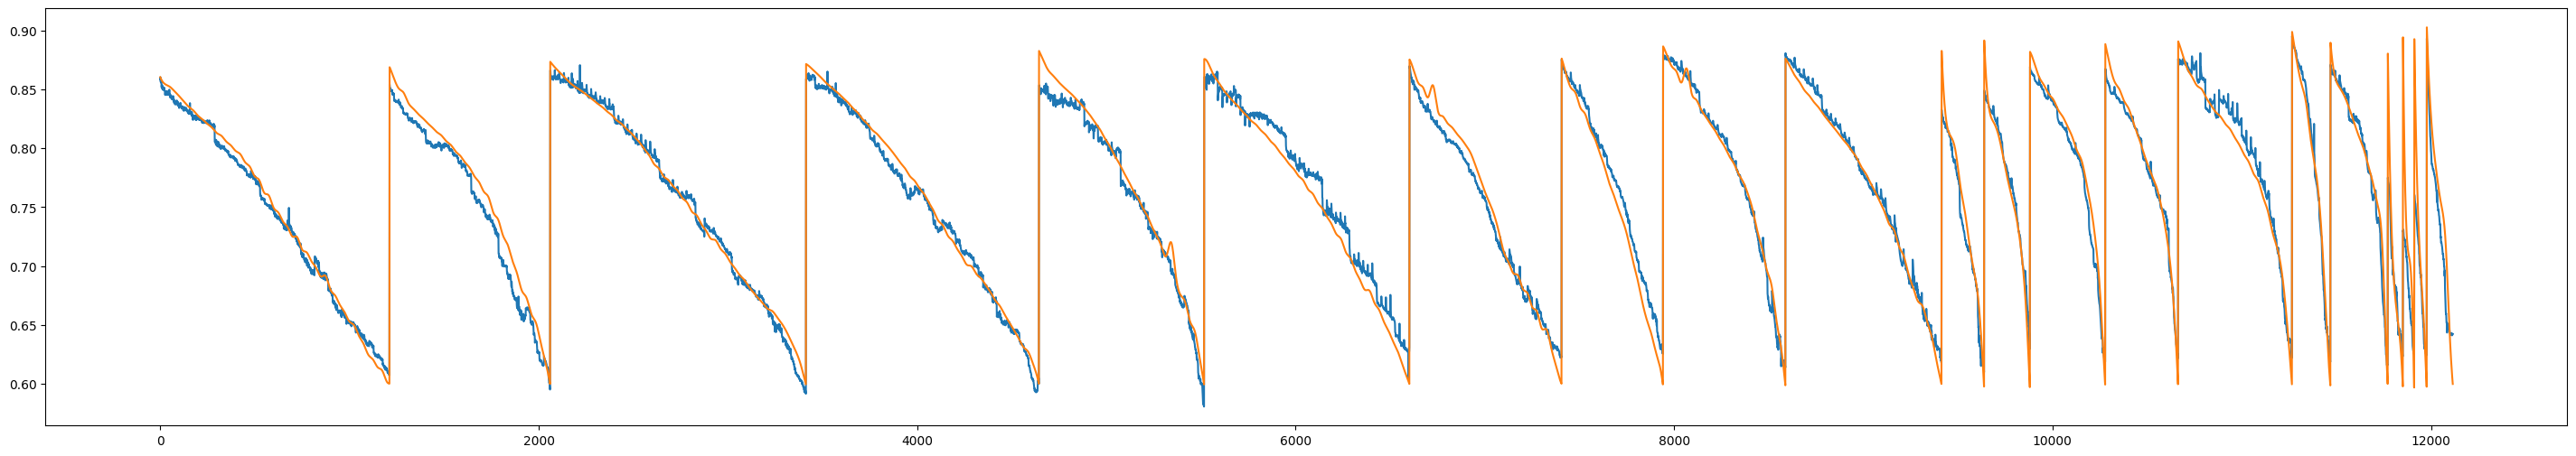

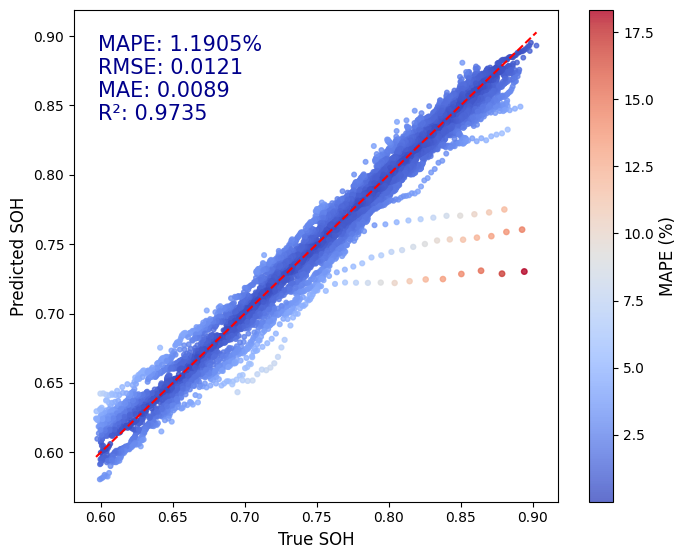

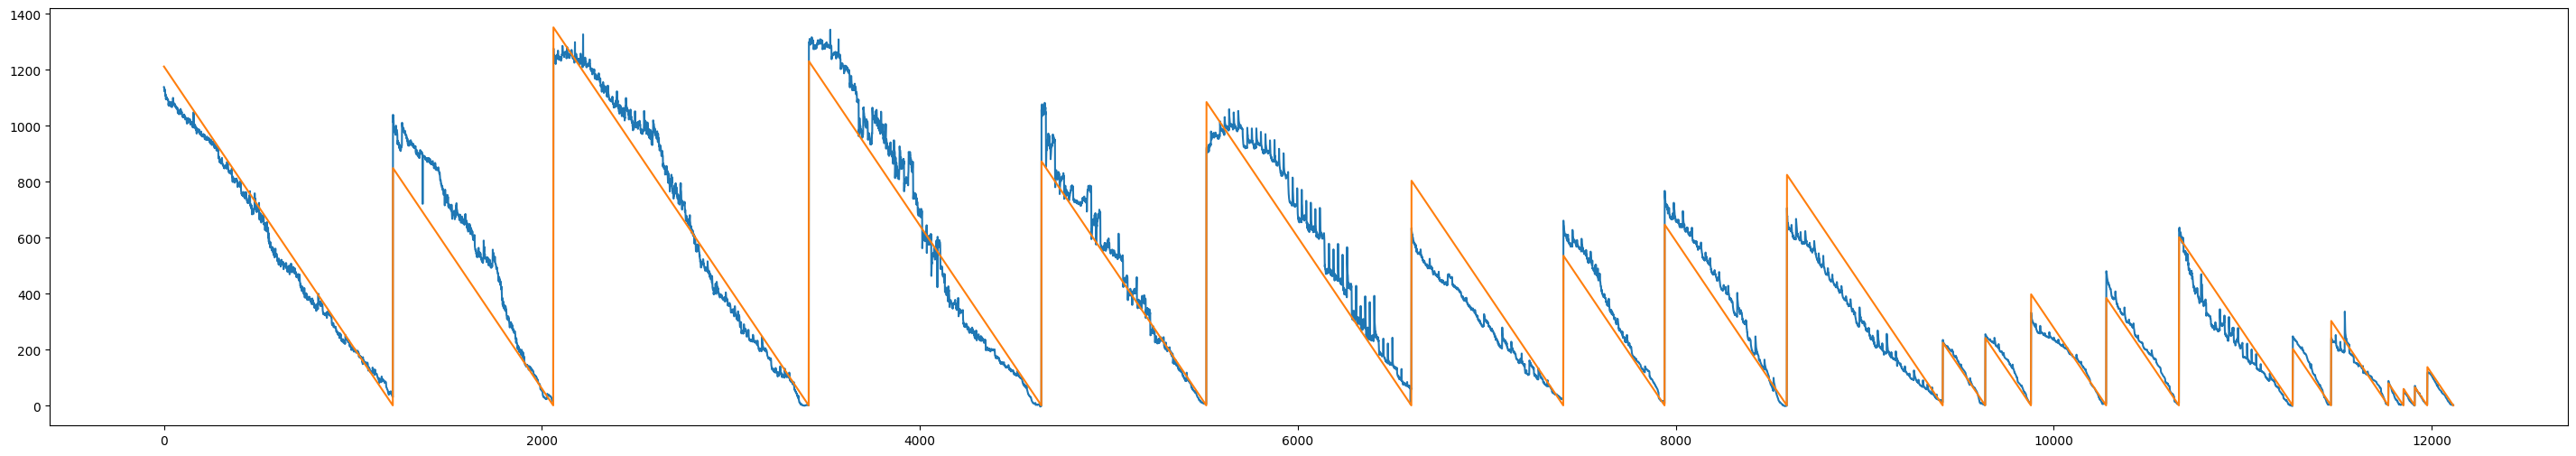

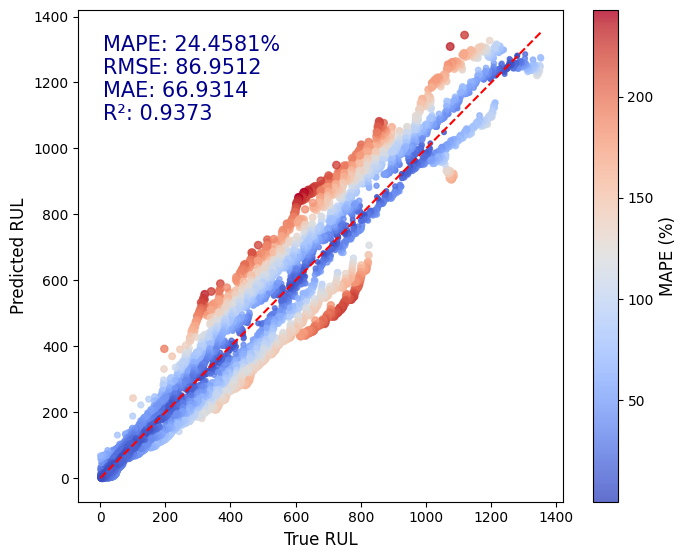

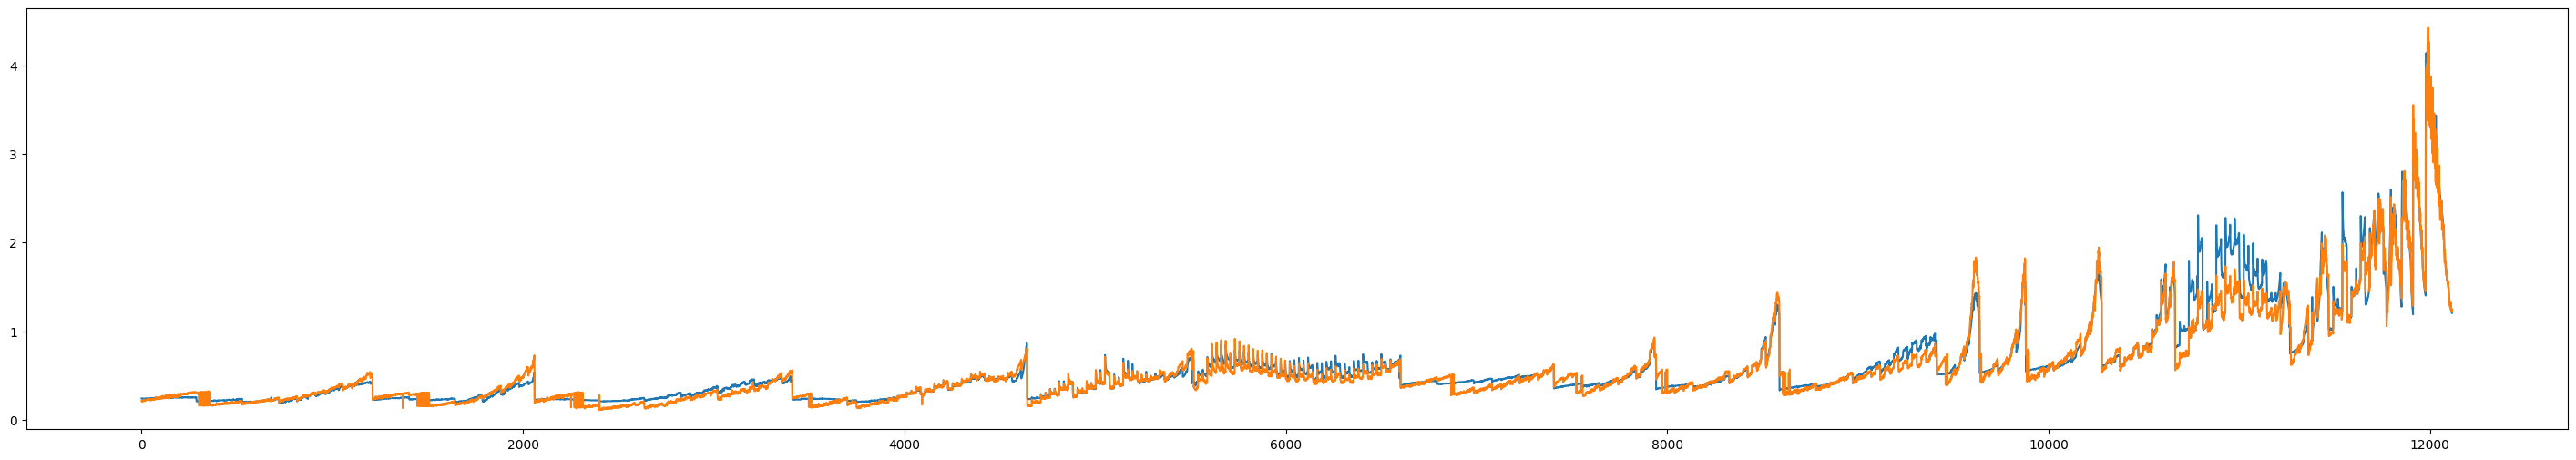

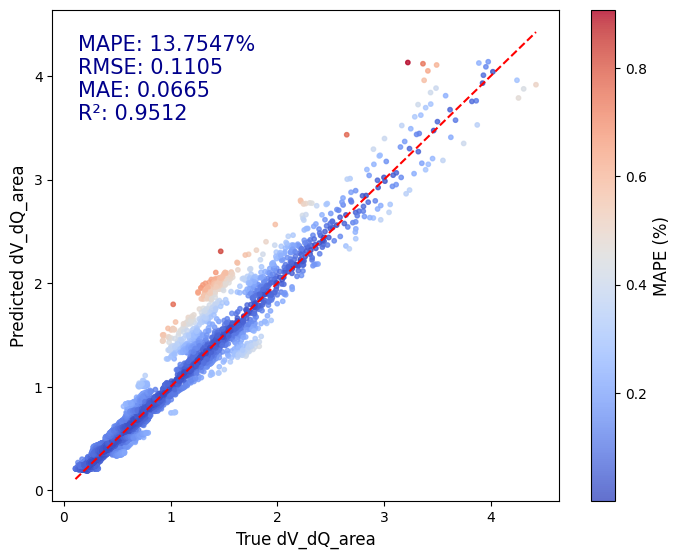

0.9554071426391602


In [14]:
# =============== Model Evaluation ===============

# Test without uncertainty estimation
test_rmse1, test_mae1, test_mape1, test_r21, test_pred_all1, \
test_rmse2, test_mae2, test_mape2, test_r22, test_pred_all2, \
test_rmse3, test_mae3, test_mape3, test_r23, test_pred_all3 = \
    model_test(model, test_loader, test_RUL, uncertainty_state=False)

SOH Testing results 
MAPE:  0.011743441 
RMSE:  0.012042315 
MAE:  0.00879347 
R²:  0.97430885
RUL Testing results 
MAPE:  0.24771823 
RMSE:  86.58231 
MAE:  66.66258 
R²:  0.93741167
RE Testing results 
MAPE:  0.13856749 
RMSE:  0.110421374 
MAE:  0.06672507 
R²:  0.9510489


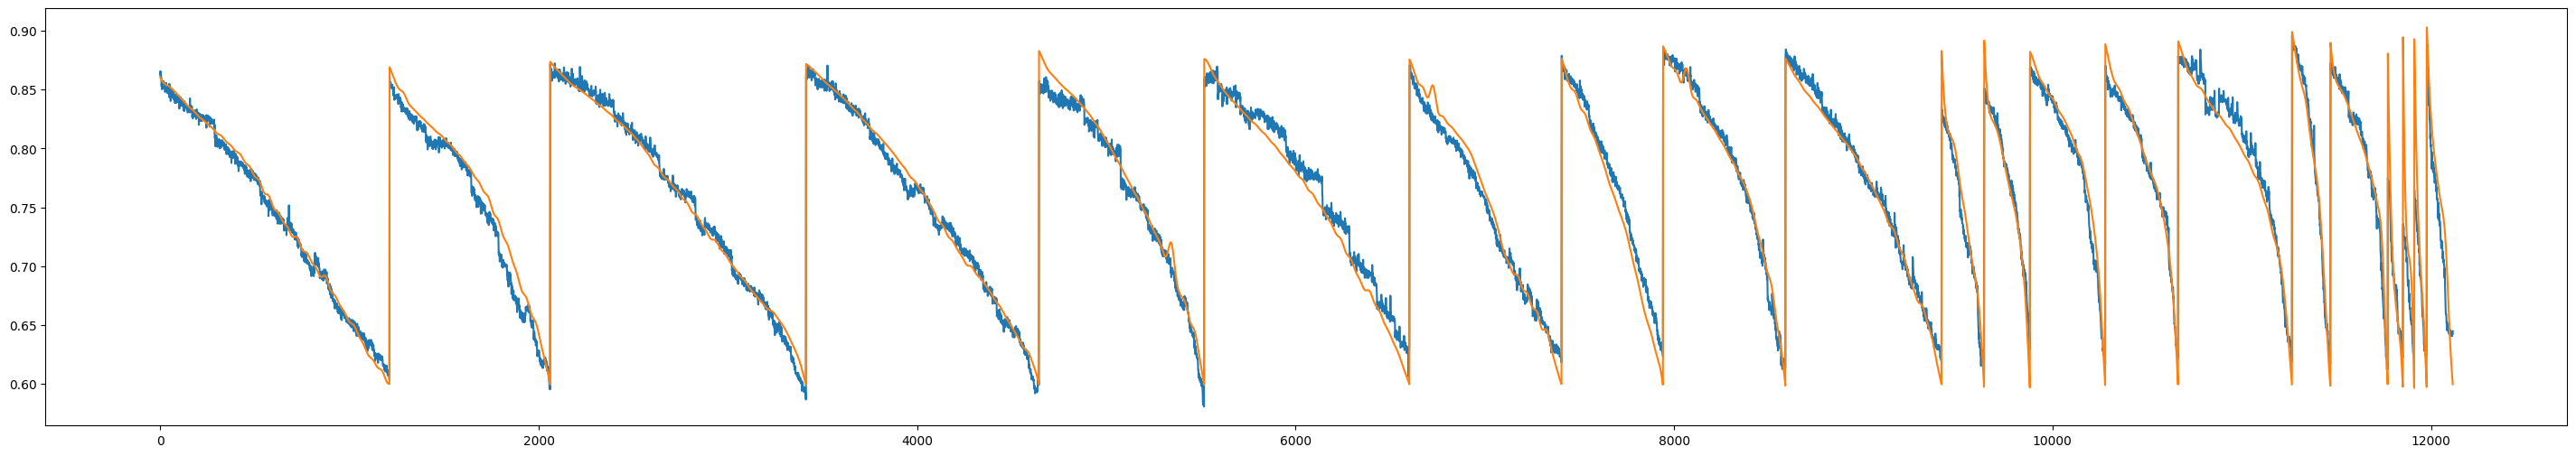

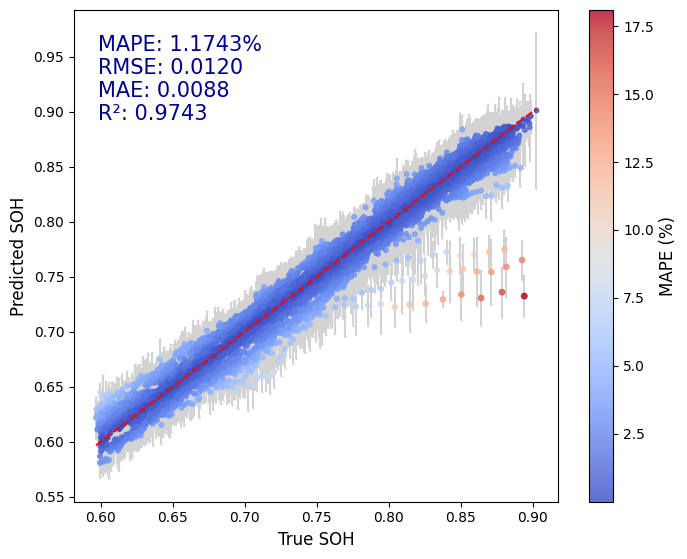

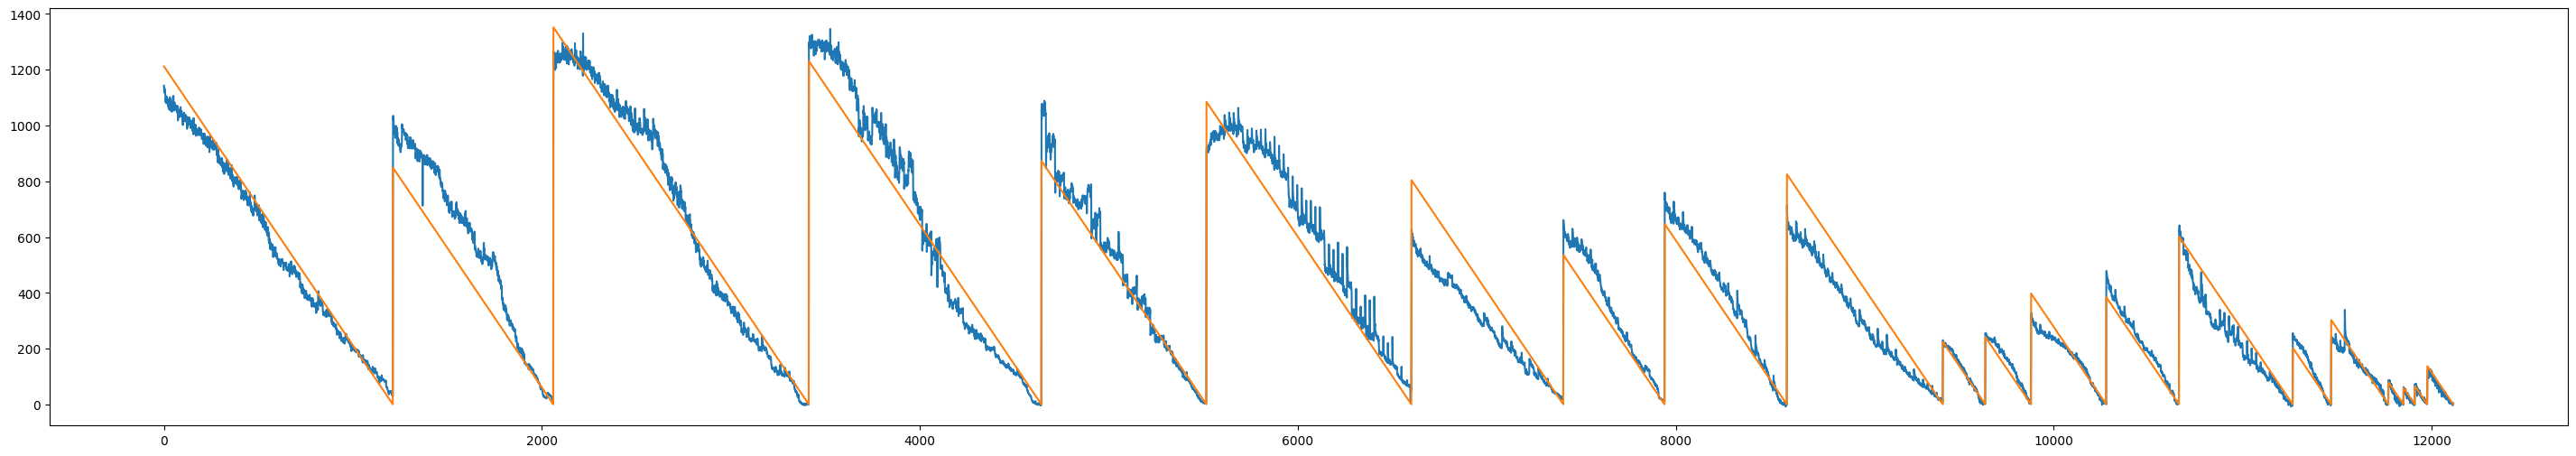

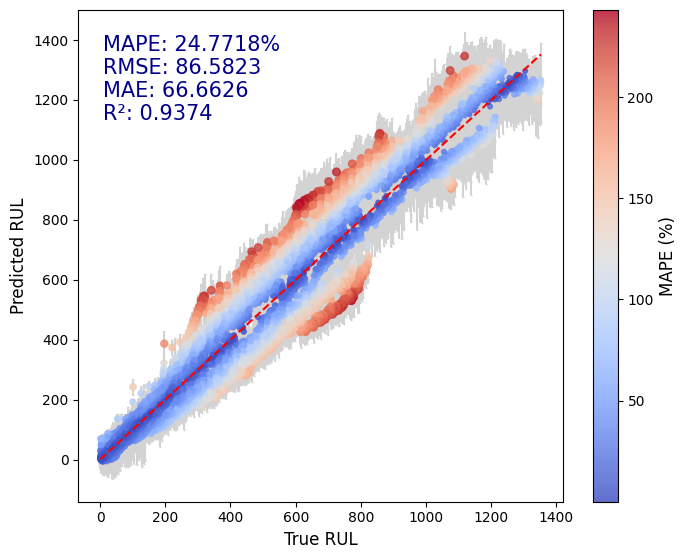

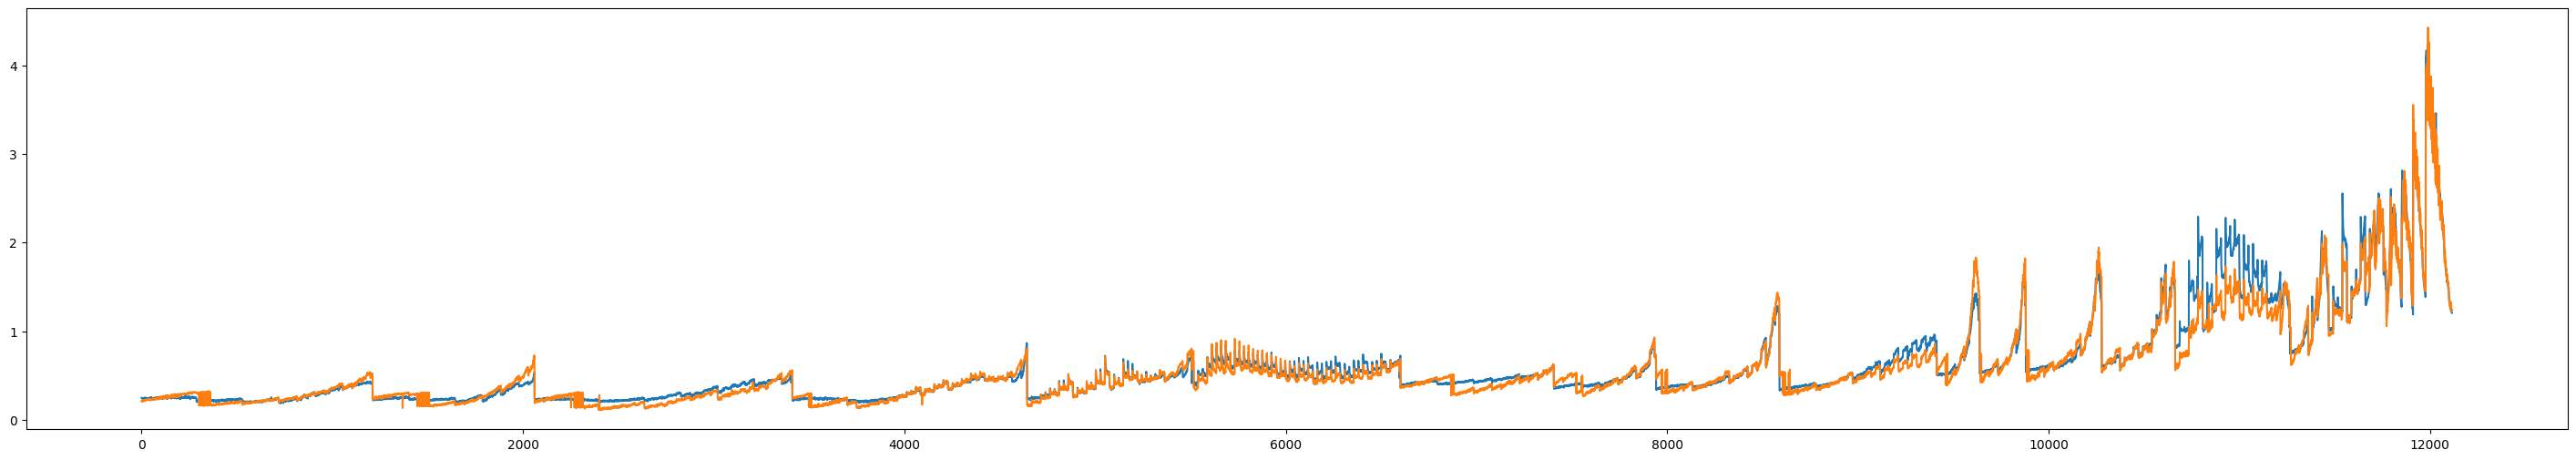

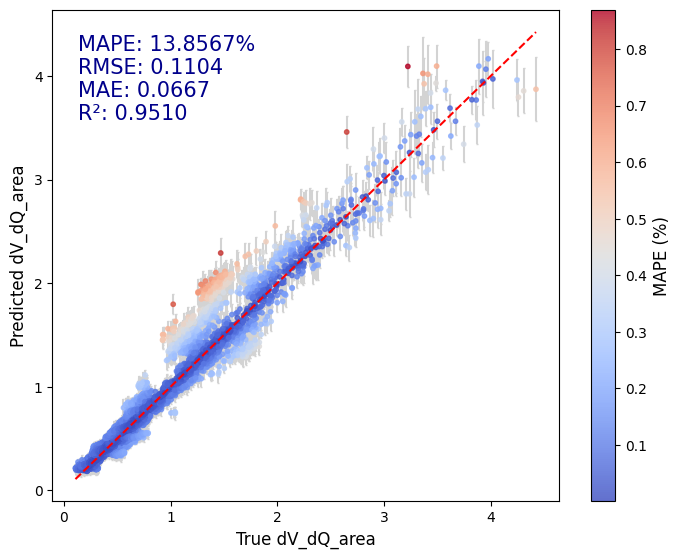

0.9558602571487427


In [15]:
# Test with uncertainty estimation
test_rmse1, test_mae1, test_mape1, test_r21, test_pred_all1, test_pred_std1, \
test_rmse2, test_mae2, test_mape2, test_r22, test_pred_all2, test_pred_std2, \
test_rmse3, test_mae3, test_mape3, test_r23, test_pred_all3, test_pred_std3 = \
    model_test(model, Test_loader, test_RUL, uncertainty_state=True)